In [1]:

from sklearn.model_selection import train_test_split
import pandas as pd
#set verbose to 0 so that it prints from the callback function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,GlobalAveragePooling1D


Using TensorFlow backend.


In [22]:
#load data

print('Loading data...')

#4 datasets
#CYP1A2_fixpka.smi
#CYP2C19_substrate_fixpka.smi
#CYP2D6_fixpka.smi
#CYP3A4_fixpka.smi

datasetFile='CYP1A2_fixpka.smi'
dataset = pd.read_csv(datasetFile, sep= ' ', header=None)
X_SMILES, y = dataset.iloc[:,:-1], dataset.iloc[:, -1]

#Library of unique characters. The first element is not used for padding
char_lib=["ZMY"]

#Find characters of sequences and build a library
for index, SMILESsequence in X_SMILES.iterrows():
    for letter in SMILESsequence[0]:
        if not letter in char_lib:            
            char_lib.append(letter)

X=[]
#SMILES sequence to an array
for index, SMILESsequence in X_SMILES.iterrows():
    sequenceArray=[]
    for letter in SMILESsequence[0]:
        sequenceArray.append(char_lib.index(letter))
    X.append(sequenceArray)
    
print('data loaded')

Loading data...
data loaded


In [32]:
#add zeros
X=sequence.pad_sequences(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1024)

max_features = len(char_lib)
maxlen = X_train.shape[1]

In [24]:
print(X_train.shape)
print(max_features)
print(maxlen)

(11922, 226)
43
226


In [25]:
import numpy as np
from keras.callbacks import Callback
class CustomCallbacks(Callback):
    def __init__(self, filename="best_weight.hdf5", monitor='val_acc', patience=10):
        super(Callback, self).__init__()
        self.filename = filename
        self.monitor = monitor
        self.patience = patience

        self.wait = 0
        
        if 'acc' in self.monitor or 'val_acc' in self.monitor:
                self.monitor_op = np.greater
                self.best = -np.Inf
        else:
                self.monitor_op = np.less
                self.best = np.Inf
        self.losses = []
        self.acc = []
        self.val_acc =[]
        self.val_losses=[]             

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.val_losses.append(logs.get('val_loss'))   
        print("acc: %0.3f" % logs.get('acc'), 
              ", loss: %0.3f" % logs.get('loss'),
              ", val_acc: %0.3f" % logs.get('val_acc'),
              ", val_loss: %0.3f" % logs.get('val_loss'))        
        
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
        else:
            if self.monitor_op(current, self.best):
                print('Epoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch, self.monitor, self.best,
                                     current, self.filename))
                self.best = current                       
                self.wait = 0
                self.model.save(self.filename, overwrite=True)
            else:
                print('Epoch %05d: %s did not improve' %  (epoch, self.monitor))
                if self.wait >= self.patience:                   
                    self.model.stop_training = True
                self.wait += 1

    def on_train_end(self, logs=None):
        if self.wait >= self.patience:
            print('Warning: early stopping')
        self.wait=0
        if 'acc' in self.monitor or 'val_acc' in self.monitor:
                self.monitor_op = np.greater
                self.best = -np.Inf
        else:
                self.monitor_op = np.less
                self.best = np.In
        
my_callbacks=CustomCallbacks(filename="CYP1A2_conv1.hdf5", monitor='val_acc', patience=np.Inf)


In [26]:
from keras.layers.pooling import MaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.recurrent import LSTM 

In [29]:



model = Sequential()
model.add(Embedding(input_dim=max_features,output_dim=50, input_length=maxlen))
model.add(Dropout(0.5))

model.add(Conv1D(filters=500,kernel_size=7, padding='valid', strides=1))
model.add(LeakyReLU(0.3))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())

model.add(Dense(500))
model.add(Dropout(0.5))
model.add(LeakyReLU(0.3))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



In [9]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 226, 50)           2150      
_________________________________________________________________
dropout_1 (Dropout)          (None, 226, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 220, 500)          175500    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 220, 500)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 220, 500)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
__________

In [ ]:
model.fit(X_train, y_train,
          batch_size=100,
          epochs=100,
          callbacks=[my_callbacks],
          validation_data=(X_test,y_test),
          verbose=0) 

acc: 0.818 , loss: 0.405 , val_acc: 0.803 , val_loss: 0.420
Epoch 00000: val_acc improved from -inf to 0.80342, saving model to CYP1A2_conv1.hdf5
acc: 0.821 , loss: 0.399 , val_acc: 0.795 , val_loss: 0.434
Epoch 00001: val_acc did not improve
acc: 0.816 , loss: 0.404 , val_acc: 0.776 , val_loss: 0.451
Epoch 00002: val_acc did not improve
acc: 0.818 , loss: 0.403 , val_acc: 0.778 , val_loss: 0.450
Epoch 00003: val_acc did not improve
acc: 0.821 , loss: 0.400 , val_acc: 0.780 , val_loss: 0.449
Epoch 00004: val_acc did not improve
acc: 0.824 , loss: 0.397 , val_acc: 0.803 , val_loss: 0.424
Epoch 00005: val_acc did not improve
acc: 0.820 , loss: 0.395 , val_acc: 0.789 , val_loss: 0.440
Epoch 00006: val_acc did not improve
acc: 0.827 , loss: 0.392 , val_acc: 0.783 , val_loss: 0.444
Epoch 00007: val_acc did not improve
acc: 0.822 , loss: 0.398 , val_acc: 0.806 , val_loss: 0.418
Epoch 00008: val_acc improved from 0.80342 to 0.80611, saving model to CYP1A2_conv1.hdf5
acc: 0.823 , loss: 0.392 ,

2912/2981 [============================>.] - ETA: 0s

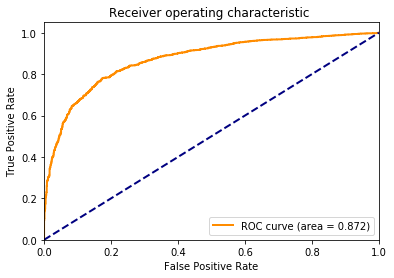

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_score=model.predict_proba(X_test)
y_score_get_value=[]
for item in y_score:
    y_score_get_value.append(item[0])
    
fpr, tpr, _ = roc_curve(y_test, y_score_get_value)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.savefig("roc.svg", format="svg")
plt.show()


